# DRL Course 2023 Домашнее задание 6 #

Отчет по выполнению домашнего задания, Nikita Sorokin

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import gym
import time
from tqdm import tqdm
from torch.distributions import Normal, Categorical

import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns

sns.set()

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 6.0)

In [2]:
def save_frames_as_gif(frames, path='./', filename='gym_animation.gif', fps=60):

    plt.figure(figsize=(frames[0].shape[1] / 50.0, frames[0].shape[0] / 50.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=fps)

## Описание алгоритма

### Proximal Policy Optimization (PPO)

Инициализируем политику $ \pi^{\eta} (a|s) $ и $ V^{\theta} (s) $ нейронными сетями. Устанавливаем $ \eta_0 $ и $ \theta_0 $

В цикле по $ k $ для $ k = \overline{1, K} $:

* По политике $ \pi^{\eta} $ получаем траекторию (или несколько) $ \tau = (S_0, \, A_0, \, ... \, S_T) $. Считаем $ (G_0, \, ... \, G_{T-1}) $.

* Определяем лосс как:

$$
Loss_1(\eta) = - \frac{1}{T} \sum_{t=0}^{T-1} \min \left\{ \frac{\pi^{\eta} (A_t | S_t)}{\pi^{\eta_k} (A_t | S_t)} A^{\theta_k} (S_t, A_t) , g_{\varepsilon} (A^{\theta_k} (S_t, A_t)) \right\}
$$

$$
Loss_2(\theta) = \frac{1}{T} \sum_{t=0}^{T-1} A^{\theta} (S_t, A_t),
$$

где $ A^{\theta} (S_t, A_t) $ = 
* $ V^{\theta} (S_t) - G_t \quad $ - advantage, полученный из Монте Карло оценки $ Q $-функции
* $ R_t + \gamma V^{\theta} (S_{t+1}) - V^{\theta} (S_t) \quad $ - advantage, полученный из уравнений Беллмана для $ Q $-функции

и обновляем параметры параметры нейронных сетей:

$$
\eta_{k + 1} \leftarrow \eta_{k} - \alpha_1 \nabla_{\eta} Loss_1(\eta_k), \quad \theta_{k + 1} \leftarrow \theta_{k} - \alpha_2 \nabla_{\theta} Loss_2(\theta_k)
$$

In [31]:
class PPO(nn.Module):
    def __init__(self, state_dim, action_dim, gamma=0.999, batch_size=128, 
                 epsilon=0.1, epoch_n=30, pi_lr=3e-4, v_lr=3e-4):

        super().__init__()
        
        self.state_dim = state_dim
        self.action_dim = action_dim

        self.pi_model = nn.Sequential(nn.Linear(self.state_dim, 128), nn.ReLU(),
                                      nn.Linear(128, 128), nn.ReLU(),
                                      nn.Linear(128, 2 * self.action_dim), nn.Tanh())
        
        self.v_model = nn.Sequential(nn.Linear(self.state_dim, 128), nn.ReLU(),
                                     nn.Linear(128, 128), nn.ReLU(),
                                     nn.Linear(128, 1))
        
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epoch_n = epoch_n
        self.pi_optimizer = torch.optim.Adam(self.pi_model.parameters(), lr=pi_lr)
        self.v_optimizer = torch.optim.Adam(self.v_model.parameters(), lr=v_lr)

    def get_action(self, state):
        mean, log_std = self.pi_model(torch.FloatTensor(state)).reshape(2, -1, self.action_dim)
        dist = Normal(mean, torch.exp(log_std))
        action = dist.sample()
        return action.numpy().reshape(self.action_dim)

    def fit(self, states, actions, rewards, dones, advantage='default'):
        
        states, actions, rewards, dones = map(np.array, [states, actions, rewards, dones])
        rewards, dones = rewards.reshape(-1, 1), dones.reshape(-1, 1)

        next_states = np.zeros_like(states)
        next_states[:-1] = states[1:]

        returns = np.zeros(rewards.shape)
        returns[-1] = rewards[-1]
        for t in range(returns.shape[0] - 2, -1, -1):
            returns[t] = rewards[t] + (1 - dones[t]) * self.gamma * returns[t + 1]

        states, next_states, actions, rewards, returns, dones = map(torch.FloatTensor, [states, next_states, actions, rewards, returns, dones])

        logits = self.pi_model(states)
        mean, log_std = logits[:, :self.action_dim], logits[:, self.action_dim:]
        
        dist = Normal(mean, torch.exp(log_std))
        old_log_probs = dist.log_prob(actions).detach()

        for epoch in range(self.epoch_n):
            
            idxs = np.random.permutation(returns.shape[0])
            for i in range(0, returns.shape[0], self.batch_size):
                b_idxs = idxs[i: i + self.batch_size]
                b_states = states[b_idxs]
                b_next_states = next_states[b_idxs]
                b_dones = dones[b_idxs]
                b_actions = actions[b_idxs]
                b_rewards = rewards[b_idxs]
                b_returns = returns[b_idxs]
                b_old_log_probs = old_log_probs[b_idxs]

                if advantage == 'default':
                    b_advantage = b_returns.detach() - self.v_model(b_states)

                if advantage == 'bellman':
                    b_advantage = b_rewards.detach() + (1 - b_dones.detach()) * self.gamma * self.v_model(b_next_states.detach()) - self.v_model(b_states) 

                if advantage == 'test':
                    b_advantage = b_rewards.detach() + (1 - b_dones.detach()) * self.gamma * self.v_model(b_next_states) - self.v_model(b_states) 

                if advantage == 'test_loss':
                    b_advantage = b_rewards.detach() + (1 - b_dones.detach()) * self.gamma * self.v_model(b_next_states) - self.v_model(b_states) 
                    
                b_logits = self.pi_model(b_states)
                b_mean, b_log_std = b_logits[:, :self.action_dim], b_logits[:, self.action_dim:]

                b_dist = Normal(b_mean, torch.exp(b_log_std))
                b_new_log_probs = b_dist.log_prob(b_actions)
    
                b_ratio = torch.exp(b_new_log_probs - b_old_log_probs)
                pi_loss_1 = b_ratio * b_advantage.detach()
                if advantage == 'test_loss':
                    pi_loss_2 = torch.clamp(b_advantage.detach(), 1. - self.epsilon,  1. + self.epsilon) * b_advantage.detach()
                else:
                    pi_loss_2 = torch.clamp(b_ratio, 1. - self.epsilon,  1. + self.epsilon) * b_advantage.detach()
                    
                pi_loss = - torch.mean(torch.min(pi_loss_1, pi_loss_2))
                
                pi_loss.backward()
                self.pi_optimizer.step()
                self.pi_optimizer.zero_grad()
                
                v_loss = torch.mean(b_advantage ** 2)
    
                v_loss.backward()
                self.v_optimizer.step()
                self.v_optimizer.zero_grad()

In [4]:
def get_trajectory(env, agent, trajectory_len=200, visualize=False, filename='gym_animation.gif'):
    trajectory = {'states':[], 'actions': [], 'rewards': [], 'dones': []}
    
    state = env.reset()

    frames = []
    for _ in range(trajectory_len):

        trajectory['states'].append(state)

        action = agent.get_action(state)
        trajectory['actions'].append(action)

        next_state, reward, done, _ = env.step(action)
        trajectory['rewards'].append(reward)
        trajectory['dones'].append(done)

        state = next_state

        if done:
            break

        if visualize:
            frames.append(env.render(mode="rgb_array"))

    if visualize:
        save_frames_as_gif(frames, filename=filename)

    return trajectory

In [5]:
def train(env, agent, episode_n=50, trajectory_n=20, trajectory_len=200, advantage='default'):
    total_rewards = []
    for episode in range(episode_n):

        states, actions, rewards, dones = [], [], [], []

        for i in range(trajectory_n):

            trajectory = get_trajectory(env, agent, trajectory_len)

            states.extend(trajectory['states'])
            actions.extend(trajectory['actions'])
            rewards.extend(trajectory['rewards'])
            dones.extend(trajectory['dones'])

            total_rewards.append(np.sum(trajectory['rewards']))

        print(f"{episode}: mean reward = {np.mean(total_rewards[-trajectory_n:])}")

        agent.fit(states, actions, rewards, dones, advantage)

    return total_rewards

In [6]:
def validation(env, agent, validation_n, trajectory_len=200):
    total_rewards = []
    for _ in range(validation_n):
        trajectory = get_trajectory(env, agent, trajectory_len)
        total_rewards.append(np.sum(trajectory['rewards']))

    return np.mean(total_rewards)

## Задание 1

Написать и исследовать другой способ представления Adavantage функции. Использовать представление вида: 

$$ A(s, a) = r + \gamma V(s') + V(s) , \quad \text{где} \,\, s'  \,\, \text{ - следующее состояние}$$

### Pendulum-v1

In [7]:
env = gym.make('Pendulum-v1')

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

c:\Users\никита\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\utils\env_checker.py:200: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


Для обучения обоих вариаций алгоритма были подобраны следующие гиперпараметры:

```python
episode_n = 50
trajectory_n = 20

gamma = 0.999
batch_size = 128 
epsilon = 0.1 
epoch_n = 30 
pi_lr = 3e-4 
v_lr = 3e-4
```

Архитектура нейронной сети: 3 линейных слоя по 128 нейронов, функция активации ReLU, на последнем слое Tanh

**Замечание**: из-за использования функции активации Tanh на последнем слое выход нейронной сети представляет действительное число в интервале от -1 до 1. В зависимости от задачи необходимо умножать выход нейронной сети на такой множитель, чтобы область определения ее выхода и область определения action совпадали (в случае, если область определения действий не симметрична относительно 0 еще делать сдвиг)

### Default

Реализация алгоритма была представлена на семинаре:

In [12]:
ppo_default50_agent = PPO(state_dim, action_dim)

In [13]:
episode_n = 25
trajectory_n = 20

ppo_default50_agent.gamma = 0.9
ppo_default50_agent.batch_size = 128 
ppo_default50_agent.epsilon = 0.2
ppo_default50_agent.epoch_n = 30 
ppo_default50_agent.pi_lr = 1e-4 
ppo_default50_agent.v_lr = 5e-4

In [14]:
ppo_default50_history = []

In [15]:
ppo_default50_rewards = train(env, ppo_default50_agent, episode_n, trajectory_n, advantage='default')

0: mean reward = -1361.3665020184562
1: mean reward = -1210.2609295907703
2: mean reward = -1178.4803101834225
3: mean reward = -1088.4758556558
4: mean reward = -1053.055066496534
5: mean reward = -932.4272470706726
6: mean reward = -864.2466634156865
7: mean reward = -868.3227131219431
8: mean reward = -748.4914716556261
9: mean reward = -685.0140587424991
10: mean reward = -597.7137205020905
11: mean reward = -568.242371824981
12: mean reward = -415.9694618202716
13: mean reward = -412.2191137960855
14: mean reward = -358.70740349555194
15: mean reward = -455.56075150466904
16: mean reward = -345.27328680998687
17: mean reward = -422.50681107888596
18: mean reward = -402.9262523332368
19: mean reward = -372.41426424115014
20: mean reward = -357.14925220393087
21: mean reward = -319.8306680985607
22: mean reward = -318.4284624502622
23: mean reward = -308.6163885417959
24: mean reward = -457.43009046698927


In [16]:
ppo_default50_history.extend(ppo_default50_rewards)

График обучения:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


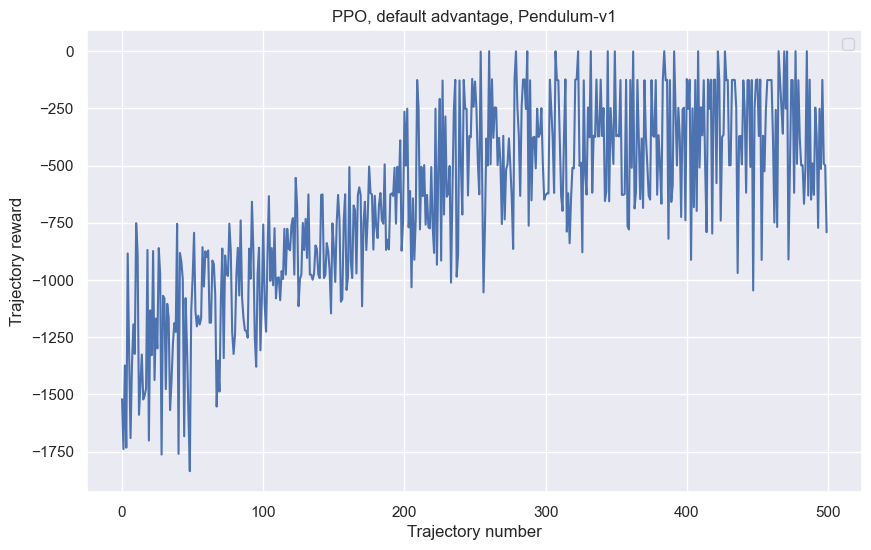

In [17]:
plt.title('PPO, default advantage, Pendulum-v1')
plt.xlabel('Trajectory number')
plt.ylabel('Trajectory reward')
plt.legend()

plt.plot(ppo_default50_history)

Валидация

In [18]:
validation_n = 100

validation_score = validation(env, ppo_default50_agent, validation_n=validation_n, trajectory_len=200)
print(f'PPO, default advantage, validation_score: {validation_score}')

PPO, default advantage, validation_score: -366.1211326246059


### Bellman

Для реализации были заведены дополнительные массивы dones и next_states, которые использовались для рассчета новой функции advantage:

```python

if advantage == 'default':
    b_advantage = b_returns.detach() - self.v_model(b_states)

if advantage == 'bellman':
    b_advantage = b_rewards.detach() + (1 - b_dones.detach()) * self.gamma * self.v_model(b_next_states.detach()) - self.v_model(b_states) 

```

In [382]:
ppo_bellman_agent = PPO(state_dim, action_dim)

In [383]:
episode_n = 10
trajectory_n = 20

In [384]:
ppo_bellman_history = []

In [ ]:
ppo_bellman_rewards = train(env, ppo_bellman_agent, episode_n, trajectory_n, advantage='bellman')

In [147]:
ppo_bellman_history.extend(ppo_bellman_rewards)

График обучения:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


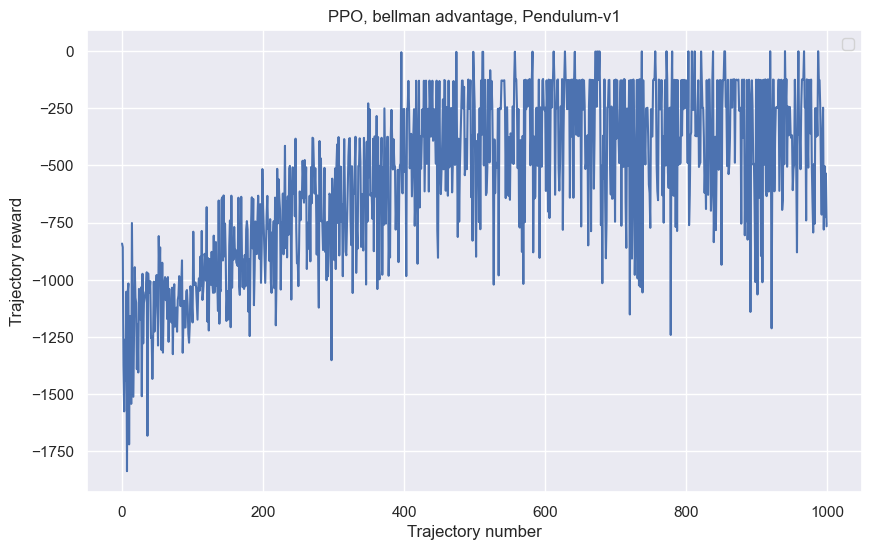

In [148]:
plt.title('PPO, bellman advantage, Pendulum-v1')
plt.xlabel('Trajectory number')
plt.ylabel('Trajectory reward')
plt.legend()

plt.plot(ppo_bellman_history)

Валидация:

In [154]:
validation_n = 100

validation_score = validation(env, ppo_bellman_agent, validation_n=validation_n, trajectory_len=200)
print(f'PPO, bellman advantage, validation_score: {validation_score}')

PPO, bellman advantage, validation_score: -305.57454480511615


Вывод: для моих гиперпараметров default advantage обучился чуть более быстрее и стабильнее чем bellman advantage

### Test

In [32]:
ppo_test_agent = PPO(state_dim, action_dim)

In [33]:
episode_n = 25
trajectory_n = 20

ppo_test_agent.gamma = 0.9
ppo_test_agent.batch_size = 128 
ppo_test_agent.epsilon = 0.2
ppo_test_agent.epoch_n = 30 
ppo_test_agent.pi_lr = 1e-4 
ppo_test_agent.v_lr = 5e-4

In [34]:
ppo_test_history = []

In [35]:
ppo_test_rewards = train(env, ppo_test_agent, episode_n, trajectory_n, advantage='test_loss')

0: mean reward = -1288.4968380345658
1: mean reward = -1203.7063733086054
2: mean reward = -1125.1744022256785
3: mean reward = -943.493511792862
4: mean reward = -1095.9978585487956
5: mean reward = -993.2992971256195
6: mean reward = -950.3185936850956
7: mean reward = -926.5221979469719
8: mean reward = -947.8212995480799
9: mean reward = -737.4150871235248
10: mean reward = -663.0354062432208
11: mean reward = -564.5640465840767
12: mean reward = -694.3277882330765
13: mean reward = -559.550591060213
14: mean reward = -572.0624275593143
15: mean reward = -617.6750373411771
16: mean reward = -393.51351935896093
17: mean reward = -526.441618521835
18: mean reward = -452.48352624124
19: mean reward = -519.2781879416003
20: mean reward = -414.03674305997595
21: mean reward = -321.4482904821986
22: mean reward = -426.16526870785054
23: mean reward = -415.6469230872509
24: mean reward = -430.195469734339


In [36]:
ppo_test_history.extend(ppo_test_rewards)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


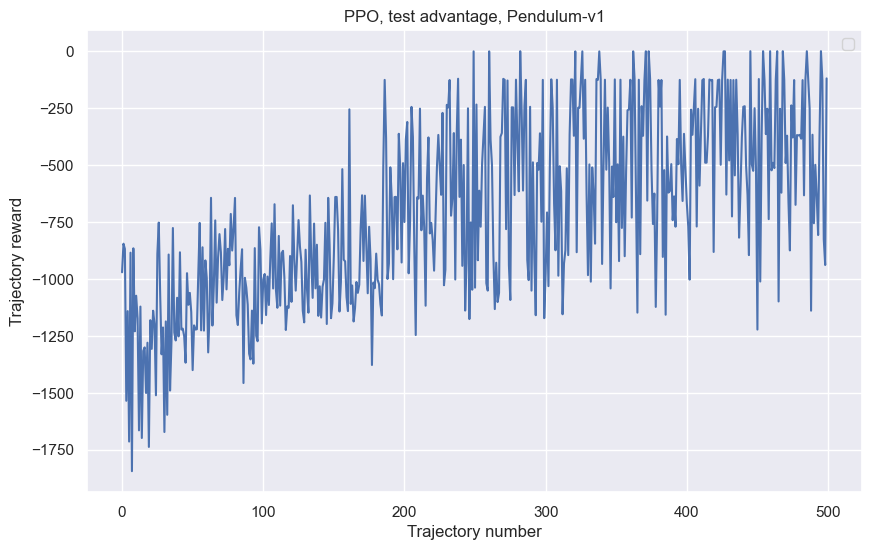

In [37]:
plt.title('PPO, test advantage, Pendulum-v1')
plt.xlabel('Trajectory number')
plt.ylabel('Trajectory reward')
plt.legend()

plt.plot(ppo_test_history)

In [30]:
validation_n = 100

validation_score = validation(env, ppo_test_agent, validation_n=validation_n, trajectory_len=200)
print(f'PPO, test advantage, validation_score: {validation_score}')

PPO, test advantage, validation_score: -1053.5636820302325


## Задание 2

Модифицировать PPO для работы в средах с многомерным пространством действий и решить с его помощью LunarLander (результат должен быть больше 100).

Для реализации многомерного PPO было проведено обобщение исходного алгоритма. Например, mean и log_std теперь определяются следующим образом:

```python
logits = self.pi_model(states)
mean, log_std = logits[:, :self.action_dim], logits[:, self.action_dim:]
```

### LunarLander-v2

In [ ]:
env = gym.make("LunarLander-v2", continuous=True)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

Для агента среды LunarLander-v2 был использован bellman advantage и следующие гиперпараметры:

```python
episode_n = 75
trajectory_n = 10
agent.epoch_n = 20

```
Остальные, как в предыдущем номере.

In [ ]:
agent = PPO(state_dim, action_dim)

In [ ]:
episode_n = 20
trajectory_n = 10
agent.epoch_n = 20

In [ ]:
#history = []

In [ ]:
rewards = train(env, agent, episode_n, trajectory_n, trajectory_len=200, advantage='bellman')
history.extend(rewards)

График обучения:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


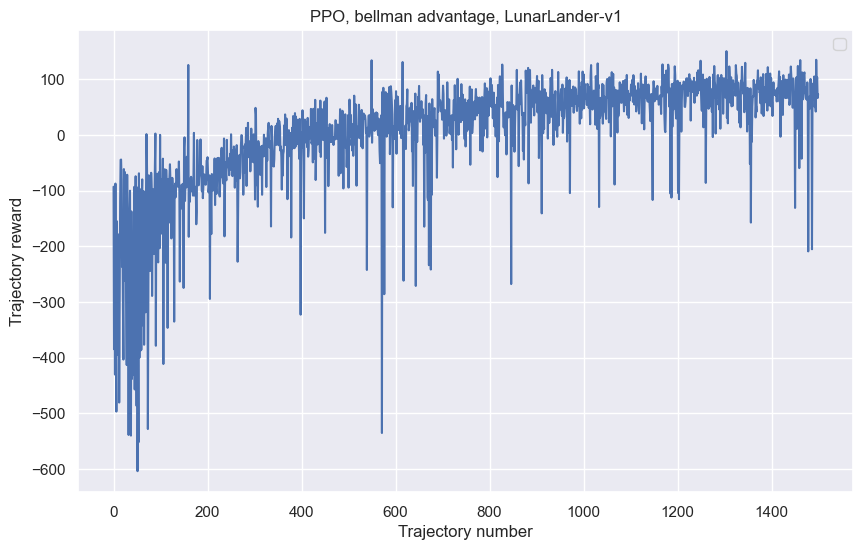

In [ ]:
plt.title('PPO, bellman advantage, LunarLander-v1')
plt.xlabel('Trajectory number')
plt.ylabel('Trajectory reward')
plt.legend()

plt.plot(history)

Валидация:

In [ ]:
validation_n = 100

validation_score = validation(env, agent, validation_n=validation_n, trajectory_len=200)
print(f'PPO, bellman advantage, validation_score: {validation_score}')

PPO, bellman advantage, validation_score: 109.5668648926394


## Задание 3

Написать PPO для работы в средах с конечным пространствам действий и решить Acrobot.

В случае непрерывного пространства действий мы пользовались представлением политики вида:

$$
\pi^{\eta} (a|s) = \mathcal{N} (a | \nu^{\eta} (s), \sigma)
$$

Теперь, имея дело с конечным пространством действий, будем представлять политику в виде:

$$
\pi^{\eta} (a|s) = \text{Softmax} (F^{\eta} (s))
$$

В реализации меняем процесс получения предсказания (добавляем Softmax) и семплирование из распределения:

```python
logits = self.pi_model(states)
probs = self.softmax(logits)

dist = Categorical(probs)
old_log_probs = dist.log_prob(actions).detach()
```

In [351]:
class DiscretePPO(nn.Module):
    def __init__(self, state_dim, action_n, gamma=0.999, batch_size=128, 
                 epsilon=0.1, epoch_n=30, pi_lr=3e-4, v_lr=3e-4):

        super().__init__()
        
        self.state_dim = state_dim
        self.action_n = action_n

        self.pi_model = nn.Sequential(nn.Linear(self.state_dim, 128), nn.ReLU(),
                                      nn.Linear(128, 128), nn.ReLU(),
                                      nn.Linear(128, self.action_n))
        
        self.v_model = nn.Sequential(nn.Linear(self.state_dim, 128), nn.ReLU(),
                                     nn.Linear(128, 128), nn.ReLU(),
                                     nn.Linear(128, 1))

        self.softmax = nn.Softmax()
        
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epoch_n = epoch_n
        self.pi_optimizer = torch.optim.Adam(self.pi_model.parameters(), lr=pi_lr)
        self.v_optimizer = torch.optim.Adam(self.v_model.parameters(), lr=v_lr)

    def get_action(self, state):
        logits = self.pi_model(torch.FloatTensor(state))
        action_prob = self.softmax(logits)
        action_prob = action_prob.detach().numpy()
        action = np.random.choice(self.action_n, p=action_prob)

        return action

    def fit(self, states, actions, rewards, dones, advantage='default'):
        
        states, actions, rewards, dones = map(np.array, [states, actions, rewards, dones])
        rewards, dones = rewards.reshape(-1, 1), dones.reshape(-1, 1)

        next_states = np.zeros_like(states)
        next_states[:-1] = states[1:]

        returns = np.zeros(rewards.shape)
        returns[-1] = rewards[-1]
        for t in range(returns.shape[0] - 2, -1, -1):
            returns[t] = rewards[t] + (1 - dones[t]) * self.gamma * returns[t + 1]

        states, next_states, actions, rewards, returns, dones = map(torch.FloatTensor, [states, next_states, actions, rewards, returns, dones])

        logits = self.pi_model(states)
        probs = self.softmax(logits)

        dist = Categorical(probs)
        old_log_probs = dist.log_prob(actions).detach()

        for epoch in range(self.epoch_n):
            
            idxs = np.random.permutation(returns.shape[0])
            for i in range(0, returns.shape[0], self.batch_size):
                b_idxs = idxs[i: i + self.batch_size]
                b_states = states[b_idxs]
                b_next_states = next_states[b_idxs]
                b_dones = dones[b_idxs]
                b_actions = actions[b_idxs]
                b_rewards = rewards[b_idxs]
                b_returns = returns[b_idxs]
                b_old_log_probs = old_log_probs[b_idxs]

                if advantage == 'default':
                    b_advantage = b_returns.detach() - self.v_model(b_states)

                if advantage == 'bellman':
                    b_advantage = b_rewards.detach() + (1 - b_dones.detach()) * self.gamma * self.v_model(b_next_states.detach()) - self.v_model(b_states) 
                    
                b_logits = self.pi_model(b_states)
                b_probs = self.softmax(b_logits)

                b_dist = Categorical(b_probs)
                b_new_log_probs = b_dist.log_prob(b_actions)
    
                b_ratio = torch.exp(b_new_log_probs - b_old_log_probs)
                pi_loss_1 = b_ratio * b_advantage.detach()
                pi_loss_2 = torch.clamp(b_ratio, 1. - self.epsilon,  1. + self.epsilon) * b_advantage.detach()
                pi_loss = - torch.mean(torch.min(pi_loss_1, pi_loss_2))
                
                pi_loss.backward()
                self.pi_optimizer.step()
                self.pi_optimizer.zero_grad()
                
                v_loss = torch.mean(b_advantage ** 2)
    
                v_loss.backward()
                self.v_optimizer.step()
                self.v_optimizer.zero_grad()


### Acrobot-v1

In [367]:
env = gym.make('Acrobot-v1')

state_dim = env.observation_space.shape[0]
action_n = env.action_space.n

Для обучения понадобилось чуть больше эпизодов и эпох во время fit, также использовался default advantage:

```python
episode_n = 100
trajectory_n = 20
epoch_n = 30
```

In [368]:
ppo_discrete_agent = DiscretePPO(state_dim, action_n)

In [369]:
ppo_discrete_agent.epsilon = 0.2

In [370]:
episode_n = 100
trajectory_n = 20
ppo_discrete_agent.epoch_n = 30

In [371]:
ppo_discrete_history = []

In [372]:
ppo_discrete_rewards = train(env, ppo_discrete_agent, episode_n, trajectory_n, advantage='default')

0: mean reward = -200.0
1: mean reward = -200.0
2: mean reward = -200.0
3: mean reward = -200.0
4: mean reward = -200.0
5: mean reward = -200.0
6: mean reward = -200.0
7: mean reward = -200.0
8: mean reward = -200.0
9: mean reward = -200.0
10: mean reward = -200.0
11: mean reward = -200.0
12: mean reward = -200.0
13: mean reward = -200.0
14: mean reward = -200.0
15: mean reward = -200.0
16: mean reward = -200.0
17: mean reward = -200.0
18: mean reward = -200.0
19: mean reward = -200.0
20: mean reward = -198.7
21: mean reward = -199.5
22: mean reward = -200.0
23: mean reward = -200.0
24: mean reward = -196.75
25: mean reward = -198.6
26: mean reward = -196.0
27: mean reward = -197.55
28: mean reward = -199.65
29: mean reward = -197.0
30: mean reward = -197.8
31: mean reward = -195.25
32: mean reward = -192.2
33: mean reward = -190.95
34: mean reward = -187.35
35: mean reward = -194.7
36: mean reward = -187.45
37: mean reward = -188.15
38: mean reward = -184.45
39: mean reward = -188.7
4

In [373]:
ppo_discrete_history.extend(ppo_discrete_rewards)

График обучения:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


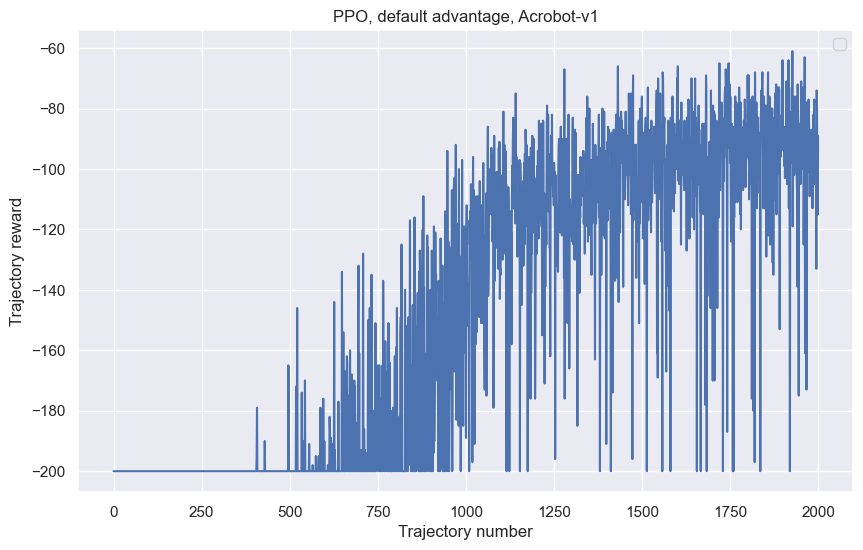

In [374]:
plt.title('PPO, default advantage, Acrobot-v1')
plt.xlabel('Trajectory number')
plt.ylabel('Trajectory reward')
plt.legend()

plt.plot(ppo_discrete_history)

Валидация:

In [376]:
validation_n = 100

validation_score = validation(env, ppo_discrete_agent, validation_n=validation_n, trajectory_len=200)
print(f'PPO, bellman advantage, validation_score: {validation_score}')

PPO, bellman advantage, validation_score: -98.2
